In [1]:
from models import NetworkedRENs, REN, RNNModel, gain
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

dtype = torch.float
device = torch.device("cpu")

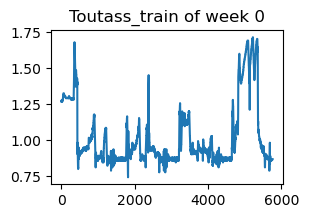

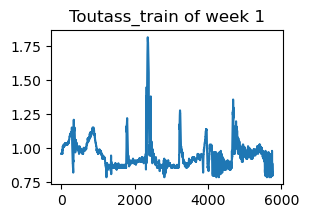

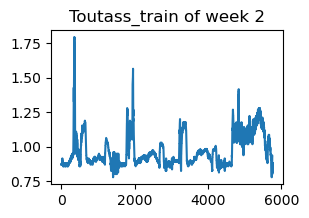

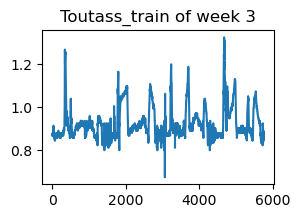

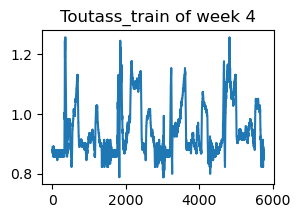

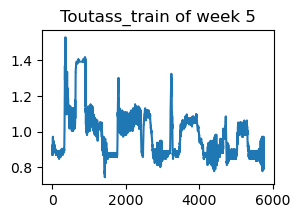

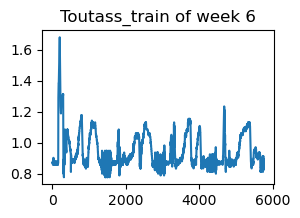

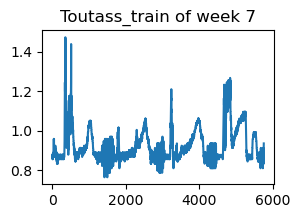

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt


# Load raw data
data = scipy.io.loadmat('raw_data.mat')

# Extract variables
Trit_GF = data['Trit_GF'].flatten()
Qhotd = data['Qhotdata'].flatten()
#statusAsst = data['statusAsstdata'].flatten()
IO_chillers = data['stato1'].flatten() + data['stato2'].flatten() + data['stato3'].flatten() + data['stato4'].flatten()
weektime = data['weektime'].flatten()
wendtime = data['wendtime'].flatten()
t = data['time'].flatten()
Text = data['Text'].flatten()
Hext = data['Hext'].flatten()
Tman_GF = data['Tman_GF'].flatten()
Toutass = data['Toutass'].flatten()
Toutchill = (data['Toutrefr1'].flatten() + data['Toutrefr2'].flatten() + data['Toutrefr3'].flatten() + data['Toutrefr4'].flatten())/4
Qu = data['buildtot'].flatten()


# Example of adjustments in Python
# Combine week and weekend times
WEEK = weektime + wendtime / 2

# Combine status variables
Status_global = data['stato1'] + data['stato2'] + data['stato3'] + data['stato4']

# Normalize data function
def normalize(data):
    mean = np.mean(data)
    data_norm = data / mean
    return mean, data_norm

# Normalize selected variables
Trit_mean, Trit_GF = normalize(Trit_GF)
Qhotd_mean, Qhotd = normalize(Qhotd)
IO_mean, IO_chillers = normalize(IO_chillers)
Tman_mean, Tman_GF = normalize(Tman_GF)
Toutass_mean, Toutass = normalize(Toutass)
Toutchill_mean, Toutchill = normalize(Toutchill)
Qu_mean, Qu = normalize(Qu)

# Adjust training data
one_week = 231840 - 221760
nb_weeks = 1  # Change as required
start = 6 * one_week
end_train = 10 * one_week
nExp = 4
t_end = 4*1440 # 4days (2 to 5)
one_day = 1440

#init the variables for outputs and inputs/disturbances
Toutchill_t = np.zeros((nExp*2, t_end))
Toutass_t = np.zeros((nExp*2, t_end))
Trit_t = np.zeros((nExp*2, t_end))
Q_users_t = np.zeros((nExp*2, t_end))
Q_abs_t = np.zeros((nExp*2, t_end))
IO_chillers_t = np.zeros((nExp*2, t_end))
Tman_t = np.zeros((nExp*2, t_end))

Toutchill_v = np.zeros((1, t_end))
Toutass_v = np.zeros((1, t_end))
Trit_v = np.zeros((1, t_end))
Q_users_v = np.zeros((1, t_end))
Q_abs_v = np.zeros((1, t_end))
IO_chillers_v = np.zeros((1, t_end))
Tman_v = np.zeros((1, t_end))

for exp in range(nExp):
    Toutchill_t[exp,:] = Toutchill[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Toutass_t[exp,:] = Toutass[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Trit_t[exp,:] = Trit_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_users_t[exp,:] = Qu[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_abs_t[exp,:] = Qhotd[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    IO_chillers_t[exp,:] = IO_chillers[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Tman_t[exp,:] = Tman_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]

    # Plotting
    plt.figure(figsize=(3, 2))
    plt.plot(Toutass_t[exp,:])
    plt.title(f'Toutass_train of week {exp}')
    plt.show()
    
Toutchill_v[0,:] = Toutchill[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Toutass_v[0,:] = Toutass[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Trit_v[0,:] = Trit_GF[ start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Q_users_v[0,:] = Qu[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Q_abs_v[0,:] = Qhotd[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
IO_chillers_v[0,:] = IO_chillers[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Tman_v[0,:] = Tman_GF[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]

for exp in range(nExp, nExp*2):
    Toutchill_t[exp,:] = Toutchill[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Toutass_t[exp,:] = Toutass[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Trit_t[exp,:] = Trit_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_users_t[exp,:] = Qu[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_abs_t[exp,:] = Qhotd[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    IO_chillers_t[exp,:] = IO_chillers[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Tman_t[exp,:] = Tman_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]

    # Plotting
    plt.figure(figsize=(3, 2))
    plt.plot(Toutass_t[exp,:])
    plt.title(f'Toutass_train of week {exp}')
    plt.show()



In [3]:
#initialize the model
ny = 1
nd = 2

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 5, 5]) # nel paper n1, numero di stati
l = np.array([10, 5, 5])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.5
beta = 0.5

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

#load RENsys
checkpoint = torch.load('network_epoch_20.pth')
RENsys.load_state_dict(checkpoint['model_state_dict'])

# Perform validation
with torch.no_grad():
    validation_loss = 0
    xi = []
    yval = torch.cat((torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutass_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Toutchill_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
    yval = yval.T
    yRENm_val = torch.randn(3, t_end, device=device, dtype=torch.float)
    yRENm_val[0, :] = yval[0, :]
    
    for j in range(N):
        xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=torch.float))
    dval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(Q_abs_v[0,:]).float().to(device).unsqueeze(1),
                    torch.from_numpy(IO_chillers_v[0,:]).float().to(device).unsqueeze(1)), dim=1)
    dval = dval.T
    xi = torch.cat(xi)
    
    for t in range(1, t_end):
        yRENm_val[:, t], xi = RENsys(t, dval[:, t - 1], xi)

    validation_loss += MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

    validation_loss = validation_loss
    print(f"Validation Loss: {validation_loss}")

C:\Users\adela\AppData\Local\Temp\ipykernel_9636\2689015723.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('network_epoch_20.pth')


Validation Loss: 0.1571812480688095


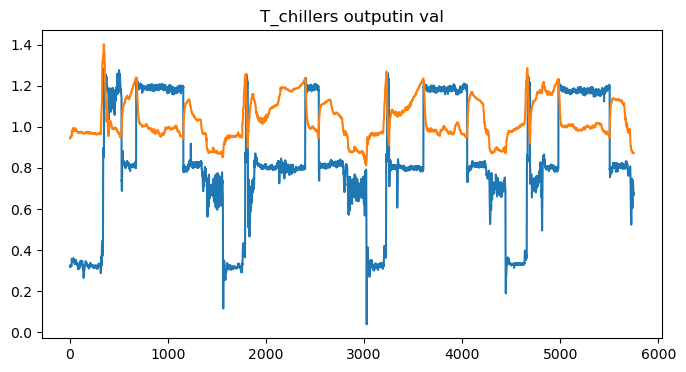

In [7]:
plt.figure(figsize=(4 * 2, 4))
for out in range(1):
    plt.subplot(1, 1, out+1)
    plt.plot(yRENm_val[out, 10:t_end].detach().numpy(), label='REN val chillers')
    plt.plot(yval[out, 10:t_end].detach().numpy(), label='y val')
    plt.title(r"T_chillers output" + r"in val")  
plt.show()